# Off the Beaten Path - Starter Notebook

## Statement of the problem
Lyra challenge is a more complex variation of a [travelling salesman](https://en.wikipedia.org/wiki/Travelling_salesman_problem) problem. Specific problem presented in this challenge introduces additional constraints and additional degrees of freedom (variables). The goal of the whole challenge is to find the most optimal plan for exploration and reward extraction. The solution of challenge is not only the plan, but also an algorithm that will be tested on other problem setups (different graphs to explore, different values of constraints), therefore you have to keep in mind, that you are developing a universal tool for finding a solution. The problem can be summarized in the below points:
### Goal
1. Goal of challenge is to develop an algorithm, which extracts as much rewards as possible in given time, budget and graph
2. Rewards are extracted from points on the graph called SITEs
3. Rewards are extracted by workers
### Scoring
1. Final score for a schedule will be calculated as profit.
2. The exact formula is simply `schedule_revenue - schedule_cost`.
### Graph/Map
1. Graph or map is a set of connected points on coordinate plane, which are called VERTICES
2. There are different types of vertices:
    * ORIGIN - a starting point for every worker
    * BASIC - regular point in graph
    * SITE - point in graph with reward, that can be extracted
3. Graph also contains EDGEs, which inform users which points are connected
### Movement
1. A movement can happen only between connected points.
2. In one timestep a worker can move one edge.
### Rewards extraction
1. Rewards are extracted from SITEs.
2. There are different types of SITEs.
3. Each type of SITE has a different reward amount, and can be accessed by specified types of workers. The extraction lasts for specified number of time steps.
4. If the extraction cannot be finished in given amount of time specified by the constraint, it cannot be started.
5. The reward from one SITE can only be extracted once. After it's extracted, it no longer produces a reward.
### Workers
1. Workers have their cost per timestep, which depletes the budget.
2. One can employ as many workers for as many timesteps as the budget allows.
3. Different worker types have different costs.
4. Different worker types can access different SITEs: e.g., a worker of type 1 can access site of type 1; a worker of type 3 can access sites of type 3.
5. A worker type of particular order can access not only site type of the same order, but also lower, e.g. worker type 3 can access sites 1, 2, 3; worker type 2 can access sites 1, 2; worker of type 1 can access only site 1.
6. Each worker has to start their journey from the ORIGIN vertex.

In [2]:
import random
from copy import deepcopy
from random import randint

import lyra_graphtool as lgtool
from lyra_graphtool import Configuration, Config_Single_Time, Edge, Graph, Graph_Type, Parameters, Vertex, Worker_Type, Vertex_Type

## Create configuration and random graph with custom parameters
During the challenge it is important to remember that given graph is not the one that final solution will be tested on. Therefore the goal is to create an algorithm that finds optimal schedule for any configuration. That's the whole reason why you are provided with tools to create your own graphs and configurations, that you may test your algorithm on.

Below we provide an example of how to create configuration with random graph based on provided parameters.
<div class="alert alert-block alert-danger"><b>Danger:</b> WARNING: IF YOU PROVIDE A GRAPH FILENAME AND GRAPH ARGUMENTS, THEN ORIGINAL GRAPH ARGUMENTS ARE GOING TO BE OVERWRITTEN WITH THE ONES PROVIDED IN LIST!!
</div>

In [15]:
duration = 40 # amount of timesteps in problem
duration = str(int(duration))
arg_list = [
    '--trial_name', 'random',    # name of trial
    '--budget', '10000',          # budget that will be used by hiring workers of different types
    '--duration', duration,      # amount of timesteps in problem
    '--worker1_cost', '200',     # Worker_Type.WORKER1 cost/timestep which reduces our budget
    '--worker2_cost', '400',     # Worker_Type.WORKER2 cost/timestep which reduces our budget
    '--worker3_cost', '600',     # Worker_Type.WORKER3 cost/timestep which reduces our budget
    ################## BELOW GRAPH ARGUMENTS ####################
    '--filename_graph', '',      # if loading graph, max_x, max_y, num_verts, graph_type, num_site[k] (k=1,2,3) ignored
    '--max_x', '100',             # max x coordinate during random or grid graph creation
    '--max_y', '100',             # max y coordinate during random or grid graph creation
    '--num_verts', '50',         # amount of vertices (travel points) that the graph will have
    '--graph_type', 'random',    # type of graph, either 'random' or 'grid' the difference between these is shown further in notebook
    '--num_site1', '3',          # amount of Vertex_Type.SITE1 on the graph mind that amount of all sites cannot be greater than 'num_verts-1'
    '--num_site2', '2',          # amount of Vertex_Type.SITE2 on the graph mind that amount of all sites cannot be greater than 'num_verts-1'
    '--num_site3', '5',          # amount of Vertex_Type.SITE3 on the graph mind that amount of all sites cannot be greater than 'num_verts-1'
    '--site1_acquire_time', '2',    # if args starting with 'site' are specified, they are imposed on loaded graph
    '--site2_acquire_time', '7',    # timesteps needed to extract Vertex_Type.SITE2 reward
    '--site3_acquire_time', '6',    # timesteps needed to extract Vertex_Type.SITE3 reward
    '--site1_reward', '300',     # reward from extracting Vertex_Type.SITE1
    '--site2_reward', '1000',     # reward from extracting Vertex_Type.SITE2
    '--site3_reward', '600',     # reward from extracting Vertex_Type.SITE3
]

`lyra_graphtool.ProcessArgs` takes care of provided arguments and creates or loads a graph. You need to initiate this object to process the argument list, that will be further passed as `lyra_graphtool.Parameters` to `lyra_graphtool.Configuration` object. You can save both parameters to a file and graph to a json file to load them later with use of `lyra_graphtool` package.

**DEMONSTRATION**
1. Create `ProcessArgs` object, save parameters and graph.
2. Load saved arguments and graph.

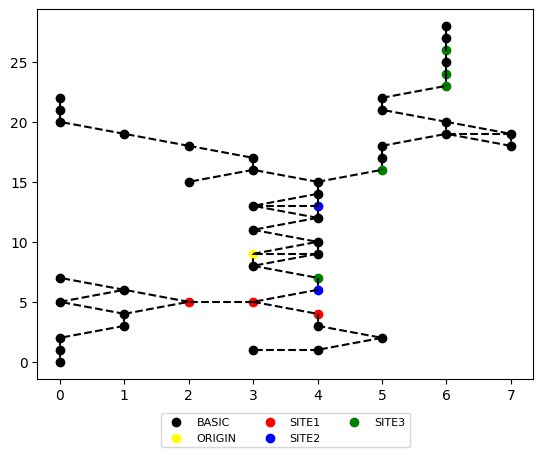

In [16]:
# set up args with above site info
pargs = lgtool.ProcessArgs(arg_list)  # default args

pargs.graph.print_graph()

pargs.graph.save_to_json(f'ready_setups/graph_{pargs.args_trial.trial_name}.json')  # save graph
pargs.save(f'ready_setups/args_{pargs.args_trial.trial_name}') # save args

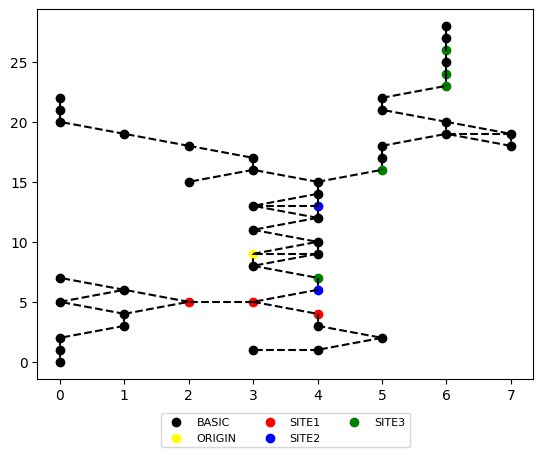

In [17]:
pargs = lgtool.ProcessArgs.load(arguments_file='ready_setups/args_random', graph_file='ready_setups/graph_random.json')
pargs.graph.print_graph()

Finally in order to create our random configuration we need to initiate `Parameters` object with graph, budget, duration time and dictionary of worker cost rates pass this object to `Configuration()`.

In [18]:
params = lgtool.Parameters(pargs.graph, 
                           budget = pargs.args_trial.budget, 
                           duration_time = pargs.args_trial.duration,
                           cost_rate = pargs.worker_cost_rate
                           )

co_base = lgtool.Configuration(params)

## Example solution - Random Walk

Below an example solution of a problem is presented. The solution hires random amount of workers, that will operate for a random amount of time, moving to random positions and accessing sites randomly with given probability. The solution works for regardless of given graph and constraints, but obviously does not provide an optimal solution. It also contains some useful functions and methods, that will be described in Chapter 5.

In [19]:
def random_alg(co_orig:lgtool.Configuration, access_probability:int = 0.5) -> int:
    
    # create config with empty scedules; ie all Config_Single_Time = (None, False)
    co = deepcopy(co_orig)
    worker_types = co.worker_types
    for wt in worker_types:
        for wn in range(len(co.config[wt])):
            for t in range(len(co.config[wt][wn])):
                co.config[wt][wn][t] = lgtool.Config_Single_Time()

    current_workers = co.get_current_workers(co.config)

    available_workers = 0
    for wt in worker_types:
        available_workers += co.max_workers[wt]

    # start all schedules at ORIGIN
    v_orig = co.graph.get_vertices_type(lgtool.Vertex_Type.ORIGIN)[0]
    cs_orig = lgtool.Config_Single_Time(v = v_orig)

    # add workers until exceed budget or no more workers available
    cost_config = co.cost()
    cost_under_budget = True
    while cost_under_budget and available_workers > 0:

        # TYPE: choose a random worker type
        enough_workers = False
        while not enough_workers:
            wt_rand = randint(0,len(worker_types)-1)
            # can we add one more worker of chosen type?
            enough_workers = current_workers[wt_rand] < co.max_workers[wt_rand]

        wt = wt_rand                   # worker type
        wn = current_workers[wt_rand]  # worker number

        sched = deepcopy(co.config[wt][wn])   # schedule to create

        w = co.get_worker(wt)

        # DURATION
        # get random duration and random start time
        duration = randint(1, co.duration_time - 1)
        time_start = randint(0, co.duration_time - duration - 1)
        time_end = time_start + duration

        # start at origin
        # add to schedule and update cost
        sched_or = deepcopy(sched)
        sched_or[time_start] = cs_orig
        co.config[wt][wn] = sched_or
        cost_config = co.cost()

        if cost_config > co.budget:
            cost_under_budget = False
            co.config[wt][wn] = sched    # set sched back to original
            continue

        # random walk
        cs_prev = cs_orig
        t = time_start + 1
        while t < time_end:

            sched = deepcopy(co.config[wt][wn])  # remember current sched

            # pick random next vertex
            verts_adj = co.graph.adjacent_vertices(cs_prev.v)
            ind_next_vert = randint(0, len(verts_adj)-1)
            v_next = verts_adj[ind_next_vert]
            # ACCESS
            if w.access(v_next) and not co.site_accessed_at_time(v_next,t):
                p = random.uniform(0,1)
                access = True if p <= access_probability else False
            else:
                access = False

            # set next Config_Single_Time's in schedule if accessing
            time_to_acq = v_next.time_to_acquire
            config_t_set = False     # True when a config is found for this case
            if access:
                if t + time_to_acq < co.duration_time:
                    # enough time to access

                    # set up schedule that accesses site
                    cs_access = lgtool.Config_Single_Time(v_next, access=True)
                    sched_access = deepcopy(sched)
                    for ta in range(t, t + time_to_acq):
                        sched_access[ta] = deepcopy(cs_access)

                    # set config schedule to access: is this within budget AND not being accessed?
                    co.config[wt][wn] = sched_access
                    feas = co.feasible()

                    if feas:
                        config_t_set = True
                        t += v_next.time_to_acquire    # move forward after access
                        cs_prev = deepcopy(cs_access)

                    else:  
                        co.config[wt][wn] = sched      # set back to original undecided sched

            if config_t_set == False:  # either not accessing, or not enough time to access
                # try no access config
                cs_no_access = lgtool.Config_Single_Time(v_next, access=False)
                sched_no_access = deepcopy(sched)
                sched_no_access[t] = deepcopy(cs_no_access)

                co.config[wt][wn] = sched_no_access

                within_budget = co.cost() < co.budget

                if within_budget:
                    config_t_set = True
                    t += 1                         # move forward after access
                    cs_prev = deepcopy(cs_no_access)
                else:  
                    co.config[wt][wn] = sched      # set back to original undecided sched
            if config_t_set == False:   # over budget in every case
                cost_under_budget = False    # break out of outside while over workers
                break                        # break out of time while

        current_workers = co.get_current_workers(co.config) # update count of current workers
        available_workers -= 1
        
    if co.cost() > 0:
        profit = co.revenue() - co.cost()
    else:
        profit = None
    
    return profit, co

In [26]:
co = deepcopy(co_base)

access_probability = 0.5   # access a site with this probability

profit, co = random_alg(co, access_probability)
random_accesses, random_message = co.get_accessed_sites(co.config)
print(f"Sites accessed: {random_accesses}")
print(random_message)

print(f'Random configuration PROFIT = {profit}.')

Sites accessed: {(4.0, 13.0): 0, (4.0, 7.0): 0, (4.0, 6.0): 0, (4.0, 4.0): 0, (3.0, 5.0): 0, (5.0, 16.0): 0, (6.0, 24.0): 0, (6.0, 26.0): 0, (6.0, 23.0): 0, (2.0, 5.0): 0}
Log of accesses:

Random configuration PROFIT = -9600.0.


In [ ]:
co.save_to_json(f'solution_{pargs.args_trial.trial_name}.json')